# DEEP LEARNING CA1 PART B: CONVOLUTIONAL NEURAL NETWORK 2

    Yek Yi Wei
    P2107631
    DAAA/FT/2B/03

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import Libraries

In [2]:
# Import Liabraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
# import keras_tuner
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Activation, Softmax, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Rescaling, BatchNormalization, SpatialDropout2D, ZeroPadding2D, Add, add
from tensorflow.keras.callbacks import History, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam


2022-11-25 12:49:04.069364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Background Research

CIFAR100 images are originally 32x32. For modern CNN architectures (such as Resnet18) we have to upscale these images to proper size (256x256). Doing this upscaling during data loading can cause CPU bottleneck. So here I have preporcessed the images to 256x256 so that you can directly load them.

### Check GPU

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for dev in physical_devices:
    print(dev)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2022-11-25 12:49:09.601484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:49:09.605023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:49:09.605203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# EDA

### LOAD TRAINING DATASET

In [4]:
tf.keras.datasets.cifar100.load_data(label_mode="fine")
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
y_train, y_test = np.concatenate(y_train), np.concatenate(y_test)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


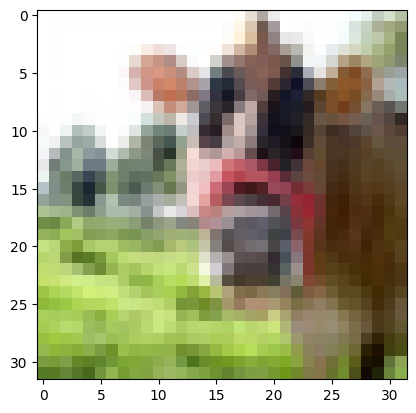

In [8]:
plt.imshow(X_train[0] , cmap=plt.cm.binary)
plt.show()

In [9]:
import pandas as pd
data=pd.DataFrame(y_test.tolist(), columns = ["Class"])
print('Train Set Class Distribution:\n')
print(data["Class"].value_counts().sort_index())


Train Set Class Distribution:

0     100
1     100
2     100
3     100
4     100
     ... 
95    100
96    100
97    100
98    100
99    100
Name: Class, Length: 100, dtype: int64


Distribution of all the classes

<AxesSubplot: title={'center': 'Distribution of classes'}>

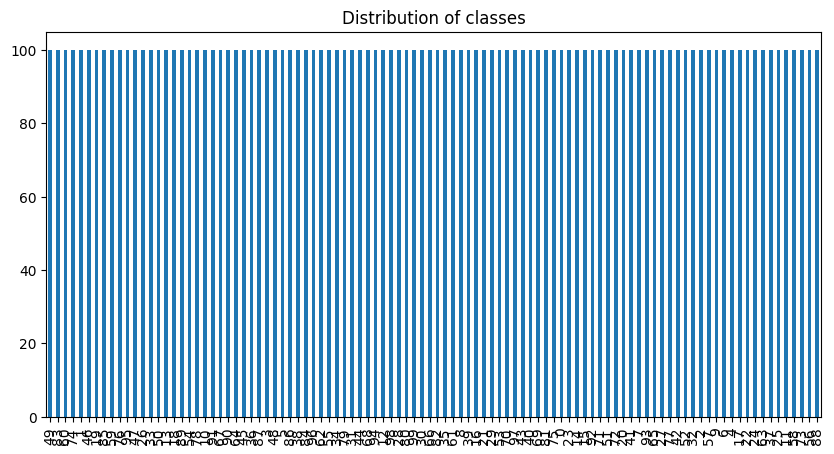

In [10]:
# Plot Distribution

plt.figure(figsize=(10, 5))
data["Class"].value_counts().plot(kind='bar',
                                          title='Distribution of classes'
                                         )

In [11]:
def ind(array, item):
    ## This function finds the index of a value
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

## Generate the index of the first occurence of each class
class_index = []
for i in np.unique(y_train):
    class_index.append(ind(y_train,i)[0])

print(class_index)

[2, 4, 202, 342, 102, 285, 55, 178, 16, 53, 244, 3, 179, 240, 51, 72, 573, 13, 75, 0, 57, 34, 35, 8, 38, 241, 150, 68, 7, 1, 133, 9, 121, 67, 120, 65, 60, 212, 83, 10, 144, 211, 28, 63, 177, 41, 77, 32, 152, 42, 71, 64, 27, 69, 167, 61, 44, 270, 378, 21, 300, 104, 141, 143, 26, 33, 86, 125, 116, 93, 22, 14, 62, 50, 20, 82, 45, 87, 40, 157, 18, 36, 12, 66, 25, 162, 5, 23, 124, 48, 6, 313, 70, 99, 112, 94, 11, 17, 58, 97]


In [12]:
# Name of all classes in CIFAR-100
class_names=  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

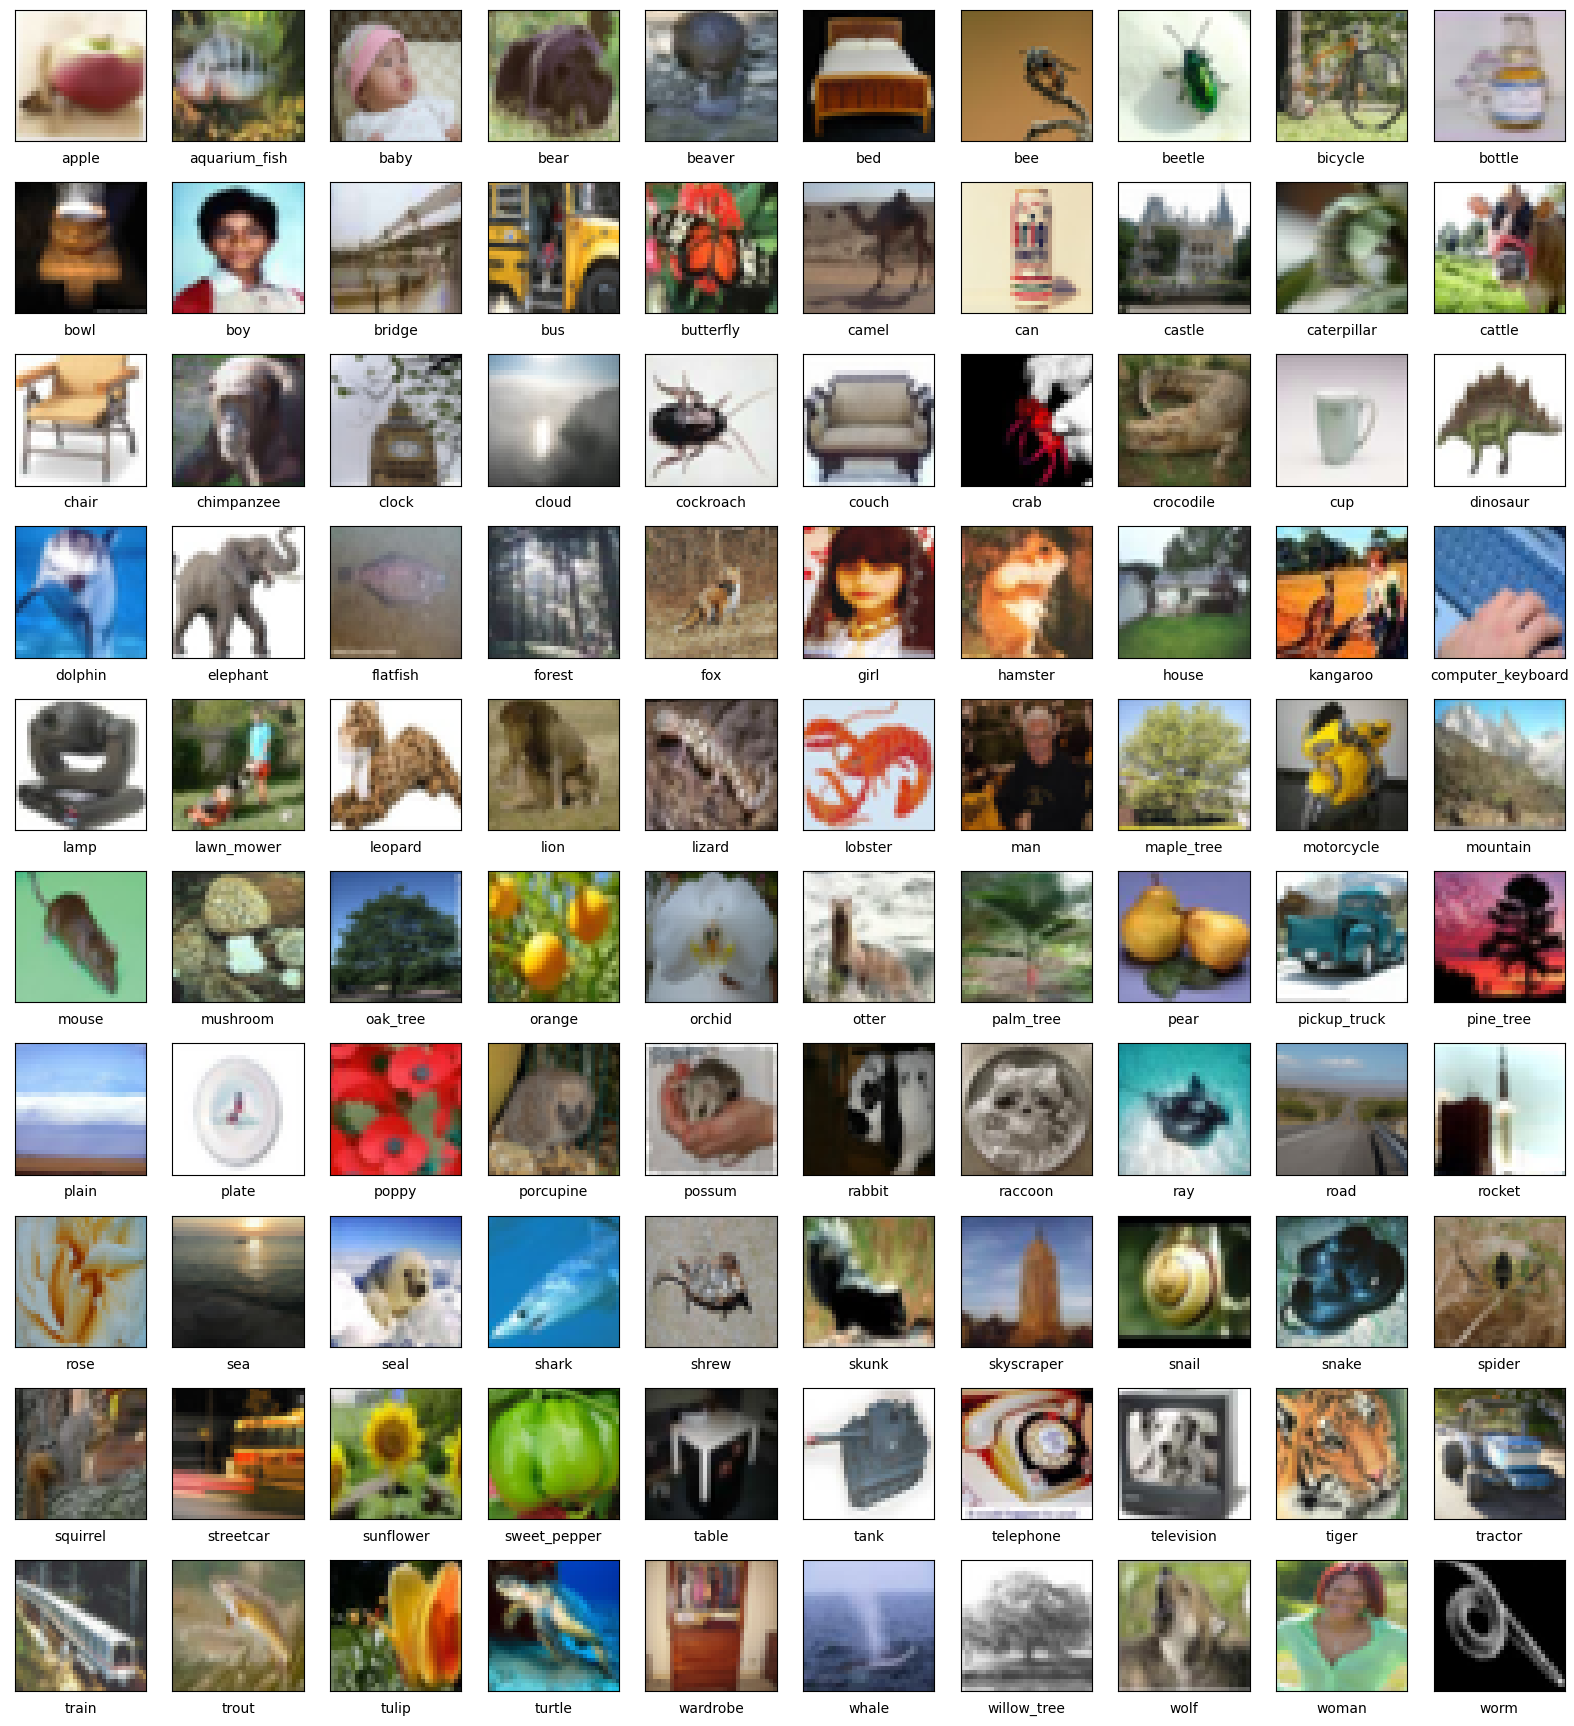

In [13]:
plt.figure(figsize=(20,22))

h, w = 10, 10
for i,val in enumerate(class_index):
    plt.subplot(h, w, i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_train[val], cmap=plt.cm.binary)

    plt.xlabel(class_names[i])

plt.show()

# DATA PREPROCESSING

    -Normalize the data
    -Scaled the values to a range of 0 to 1 before feeding to the neural network model. 
    -Divide the values by 255. 
    -The training set and the testing set are preprocessed in the same way


In [8]:
# Import libraries for preprocessing images
from tensorflow.keras.utils import to_categorical
# Normalizing the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Rescale pixel values from 0 - 255 to 0 - 1
X_train = X_train / 255
X_test = X_test / 255

# One hot encode labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


## Prepare ImageDataGenerator for data augmentation

In [10]:
# Data Augmentation
# Adding data augmentation for creating more images
# Divide train and validation set 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Configuration for creating new images
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.1
)

train_datagen.fit(X_train)

Adding the Augmented data to the default data

In [11]:
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=60000):
    X_train_aug = np.concatenate((X_train, X_batch))
    y_train_aug = np.concatenate((y_train, y_batch))
    break
print(X_train_aug.shape)
print(y_train_aug.shape)

(100000, 32, 32, 3)
(100000, 100)


# Plot Learning Curves

Plot accuracy on the training and validation datasets over training epochs.

Plot loss on the training and validation datasets over training epochs.

In [12]:
# Plot function for visualisation training process
import matplotlib.pyplot as plt

# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history['loss'], label="Train loss")
    ax1.plot(history['val_loss'], label="Validation loss")
    ax2.plot(history['acc'], label="Train accuracy")
    ax2.plot(history['val_acc'], label="Validation accuracy")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Loss per epoch', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Accuracy per epoch', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);

# Early Stopping

Early Stopping is a callback that allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
#Setting early_stopping callback
early_stopping = EarlyStopping(
    monitor='val_acc',
    patience=15,
    min_delta=0.0000001,
    restore_best_weights=True,
)

## Base Model

In [20]:
baseModel = Sequential([
    Conv2D(input_shape=(32, 32, 3), kernel_size=3, padding='same', strides=(2, 2), filters=32),
    Flatten(input_shape=(32,32,3)),
    Dense(64, activation='relu'),
    Dense(100, activation='softmax')
])

baseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 100)               6500      
                                                                 
Total params: 531,748
Trainable params: 531,748
Non-trainable params: 0
_________________________________________________________________


## Without data Augmentation

In [40]:
# Configure the model for training
from tensorflow.keras import optimizers
baseModel.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

In [47]:
#Base Model without Data augmentation
#steps_per_epoch= params divided by batch_size
# Training model
import time
training_start = time.time()
history = baseModel.fit(X_train, y_train, batch_size=64, steps_per_epoch=100, epochs=100,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
100/100 [==============================] - 6s 62ms/step - loss: 3.4017 - acc: 0.2077 - val_loss: 3.4654 - val_acc: 0.1942
Epoch 2/100
100/100 [==============================] - 4s 44ms/step - loss: 3.3743 - acc: 0.2081 - val_loss: 3.4601 - val_acc: 0.1983
Epoch 3/100
100/100 [==============================] - 4s 44ms/step - loss: 3.3620 - acc: 0.2081 - val_loss: 3.4608 - val_acc: 0.1994
Epoch 4/100
100/100 [==============================] - 4s 44ms/step - loss: 3.4062 - acc: 0.1992 - val_loss: 3.4588 - val_acc: 0.2040
Epoch 5/100
100/100 [==============================] - 4s 44ms/step - loss: 3.3971 - acc: 0.2106 - val_loss: 3.4534 - val_acc: 0.1972
Epoch 6/100
100/100 [==============================] - 5s 46ms/step - loss: 3.3892 - acc: 0.2072 - val_loss: 3.4524 - val_acc: 0.1989
Epoch 7/100
100/100 [==============================] - 4s 44ms/step - loss: 3.3829 - acc: 0.2037 - val_loss: 3.4445 - val_acc: 0.2029
Epoch 8/100
100/100 [==============================] - 5s 45ms

Model severely overfits the train data which cauzes the test data to be very low

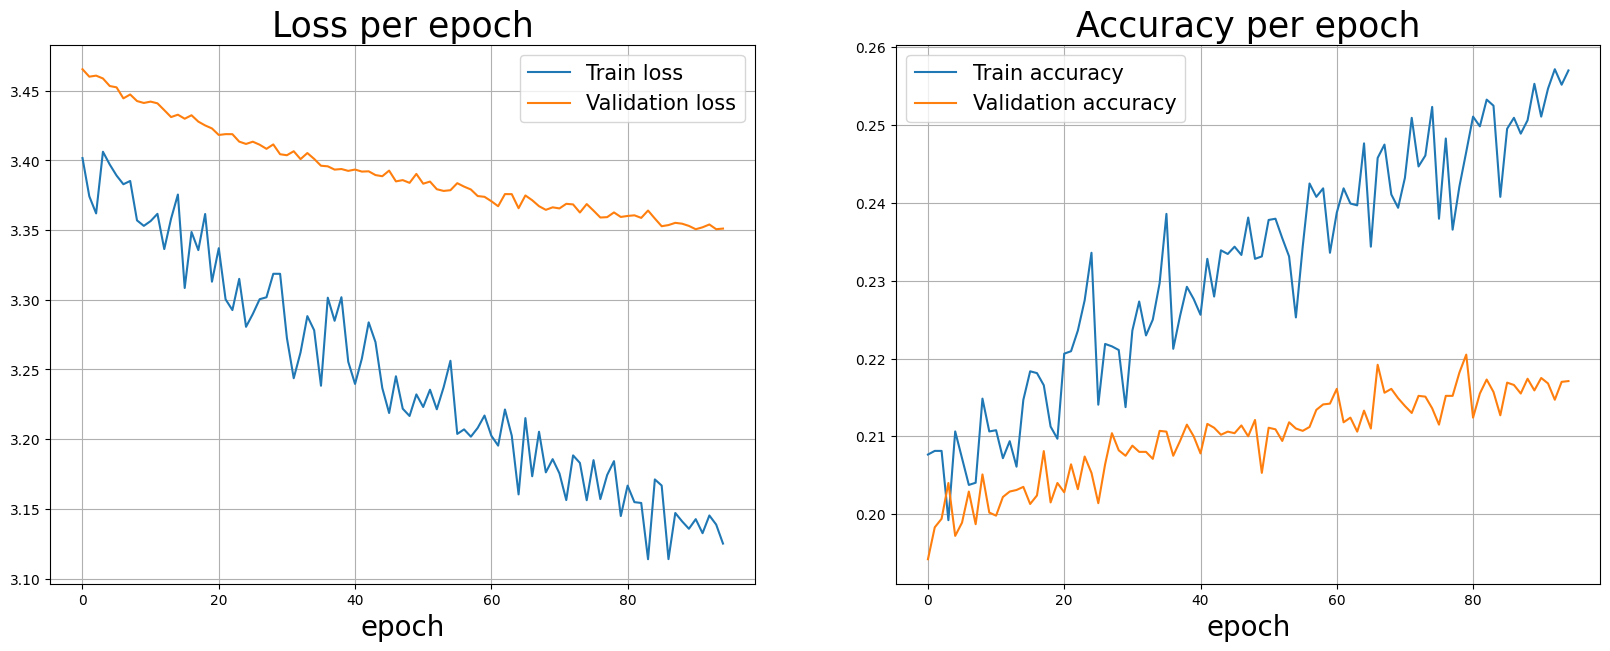

In [48]:
# plotting the learning curves
plot_results(history.history)

In [49]:
score = baseModel.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 3.359449625015259
Val accuracy: 0.22050000727176666


## With data Augmentation

In [44]:
# Training model
import time
training_start = time.time()
history = baseModel.fit(train_datagen.flow(X_train_aug, y_train_aug, batch_size=64),
          steps_per_epoch=100, 
          epochs=100,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/100
100/100 [==============================] - 24s 240ms/step - loss: 4.1953 - acc: 0.0684 - val_loss: 4.2044 - val_acc: 0.0673
Epoch 2/100
100/100 [==============================] - 24s 240ms/step - loss: 4.1634 - acc: 0.0708 - val_loss: 4.1529 - val_acc: 0.0771
Epoch 3/100
100/100 [==============================] - 24s 241ms/step - loss: 4.1459 - acc: 0.0759 - val_loss: 4.1161 - val_acc: 0.0821
Epoch 4/100
100/100 [==============================] - 24s 242ms/step - loss: 4.1023 - acc: 0.0816 - val_loss: 4.0879 - val_acc: 0.0822
Epoch 5/100
100/100 [==============================] - 24s 242ms/step - loss: 4.0485 - acc: 0.0886 - val_loss: 4.0485 - val_acc: 0.0934
Epoch 6/100
100/100 [==============================] - 24s 243ms/step - loss: 4.0334 - acc: 0.0967 - val_loss: 4.0389 - val_acc: 0.0942
Epoch 7/100
100/100 [==============================] - 24s 236ms/step - loss: 3.9899 - acc: 0.0991 - val_loss: 3.9958 - val_acc: 0.1006
Epoch 8/100
100/100 [===========================

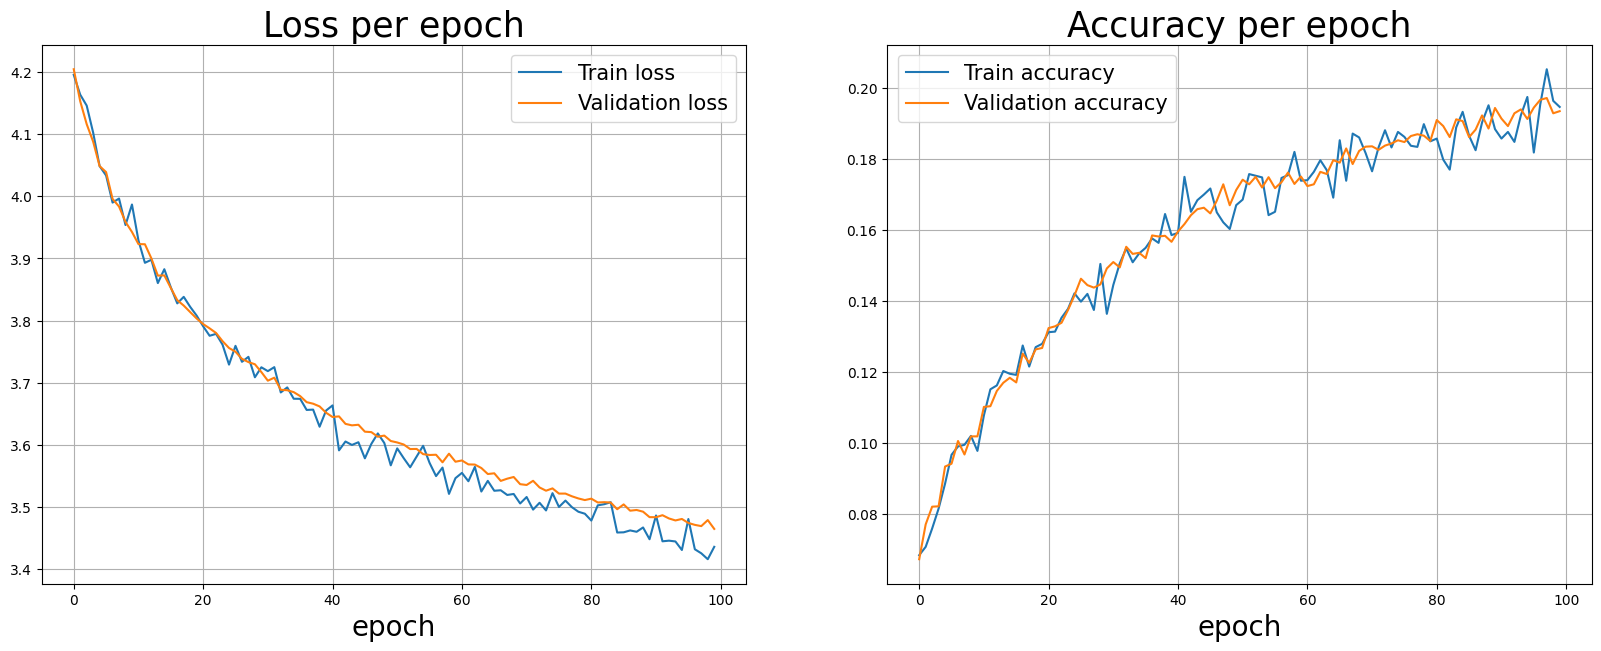

In [45]:
# plotting the learning curves
plot_results(history.history)

In [46]:
score = baseModel.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 3.464994192123413
Val accuracy: 0.19349999725818634


## Improved Model 1

In [19]:
model_improved1 = Sequential()

model_improved1.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(2, 2), padding='same', strides=(2, 2), filters=32))
model_improved1.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model_improved1.add(Conv2D(kernel_size=(2, 2), padding='same', strides=(2, 2), filters=64))
model_improved1.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model_improved1.add(Flatten())
model_improved1.add(Dense(256, activation='relu'))
model_improved1.add(Dense(128, activation='relu'))
model_improved1.add(Dense(100, activation='softmax'))

model_improved1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 16, 16, 32)        416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [20]:
# Configure the model for training
from tensorflow.keras import optimizers
model_improved1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## Without data Augmentation

In [21]:
# Training with default dataset
import time
training_start = time.time()
history = model_improved1.fit(X_train, y_train, batch_size=64, steps_per_epoch=300, epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

2022-11-25 13:31:15.652286: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/200
300/300 [==============================] - 2s 4ms/step - loss: 4.4675 - acc: 0.0370 - val_loss: 4.2992 - val_acc: 0.0517
Epoch 2/200
300/300 [==============================] - 1s 3ms/step - loss: 4.1581 - acc: 0.0759 - val_loss: 4.0237 - val_acc: 0.0956
Epoch 3/200
300/300 [==============================] - 1s 3ms/step - loss: 3.9163 - acc: 0.1108 - val_loss: 3.8664 - val_acc: 0.1181
Epoch 4/200
300/300 [==============================] - 1s 3ms/step - loss: 3.7737 - acc: 0.1362 - val_loss: 3.7204 - val_acc: 0.1420
Epoch 5/200
300/300 [==============================] - 1s 3ms/step - loss: 3.6627 - acc: 0.1551 - val_loss: 3.6192 - val_acc: 0.1617
Epoch 6/200
300/300 [==============================] - 1s 3ms/step - loss: 3.5564 - acc: 0.1752 - val_loss: 3.5354 - val_acc: 0.1758
Epoch 7/200
300/300 [==============================] - 1s 3ms/step - loss: 3.4945 - acc: 0.1821 - val_loss: 3.4765 - val_acc: 0.1863
Epoch 8/200
300/300 [==============================] - 1s 3ms/step - 

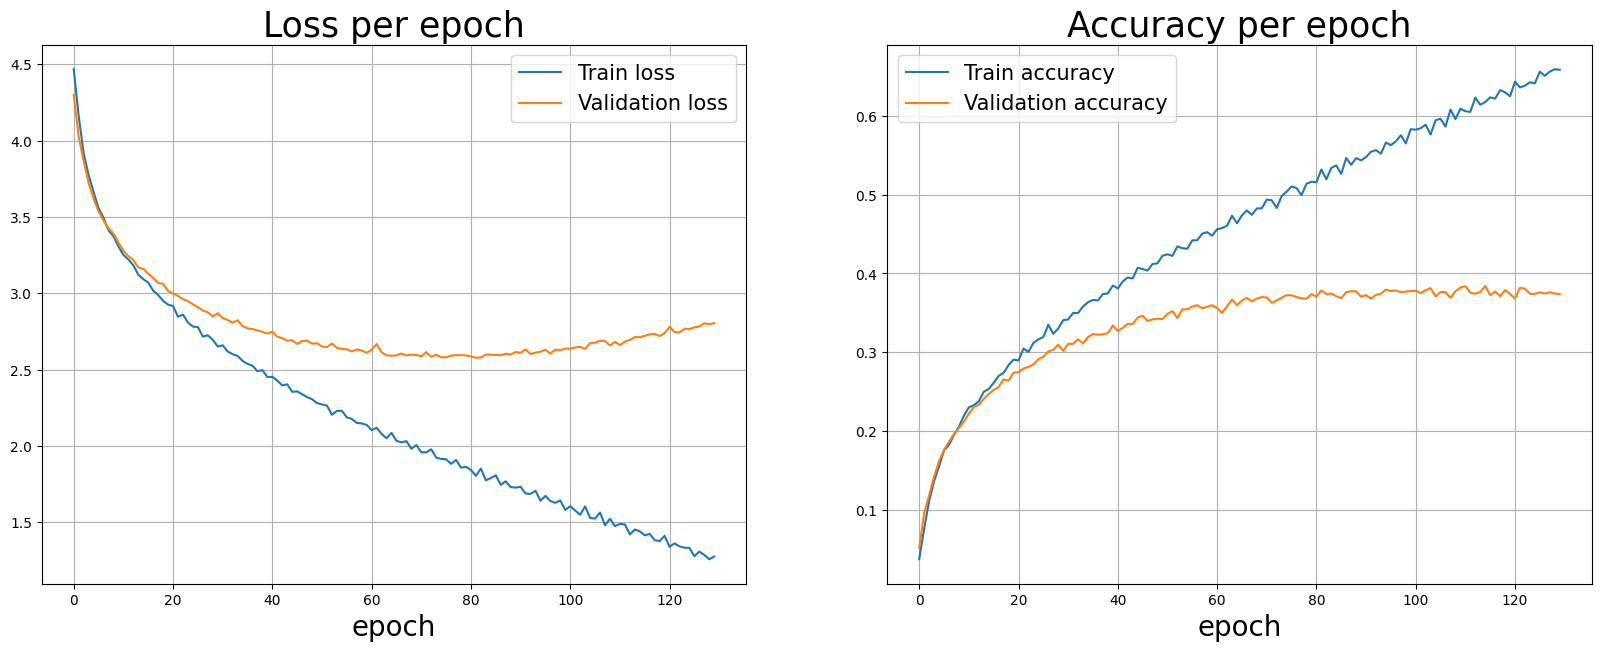

In [22]:
# plotting the learning curves
plot_results(history.history)

In [23]:
score = model_improved1.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 2.7119576930999756
Val accuracy: 0.3840000033378601


## With data Augmentation

### Using the Augmented data

In [60]:
# Training model
import time
training_start = time.time()
history = model_improved1.fit(train_datagen.flow(X_train, y_train, batch_size=64),
          steps_per_epoch=300, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/200
100/100 [==============================] - 4s 33ms/step - loss: 4.5737 - acc: 0.0225 - val_loss: 4.5234 - val_acc: 0.0286
Epoch 2/200
100/100 [==============================] - 3s 30ms/step - loss: 4.4665 - acc: 0.0364 - val_loss: 4.4148 - val_acc: 0.0372
Epoch 3/200
100/100 [==============================] - 3s 30ms/step - loss: 4.3664 - acc: 0.0433 - val_loss: 4.3060 - val_acc: 0.0628
Epoch 4/200
100/100 [==============================] - 3s 31ms/step - loss: 4.2484 - acc: 0.0658 - val_loss: 4.1929 - val_acc: 0.0733
Epoch 5/200
100/100 [==============================] - 3s 31ms/step - loss: 4.1604 - acc: 0.0770 - val_loss: 4.1197 - val_acc: 0.0825
Epoch 6/200
100/100 [==============================] - 3s 31ms/step - loss: 4.0698 - acc: 0.0809 - val_loss: 4.0503 - val_acc: 0.0965
Epoch 7/200
100/100 [==============================] - 3s 30ms/step - loss: 3.9997 - acc: 0.0983 - val_loss: 3.9679 - val_acc: 0.1044
Epoch 8/200
100/100 [==============================] - 3s 29ms

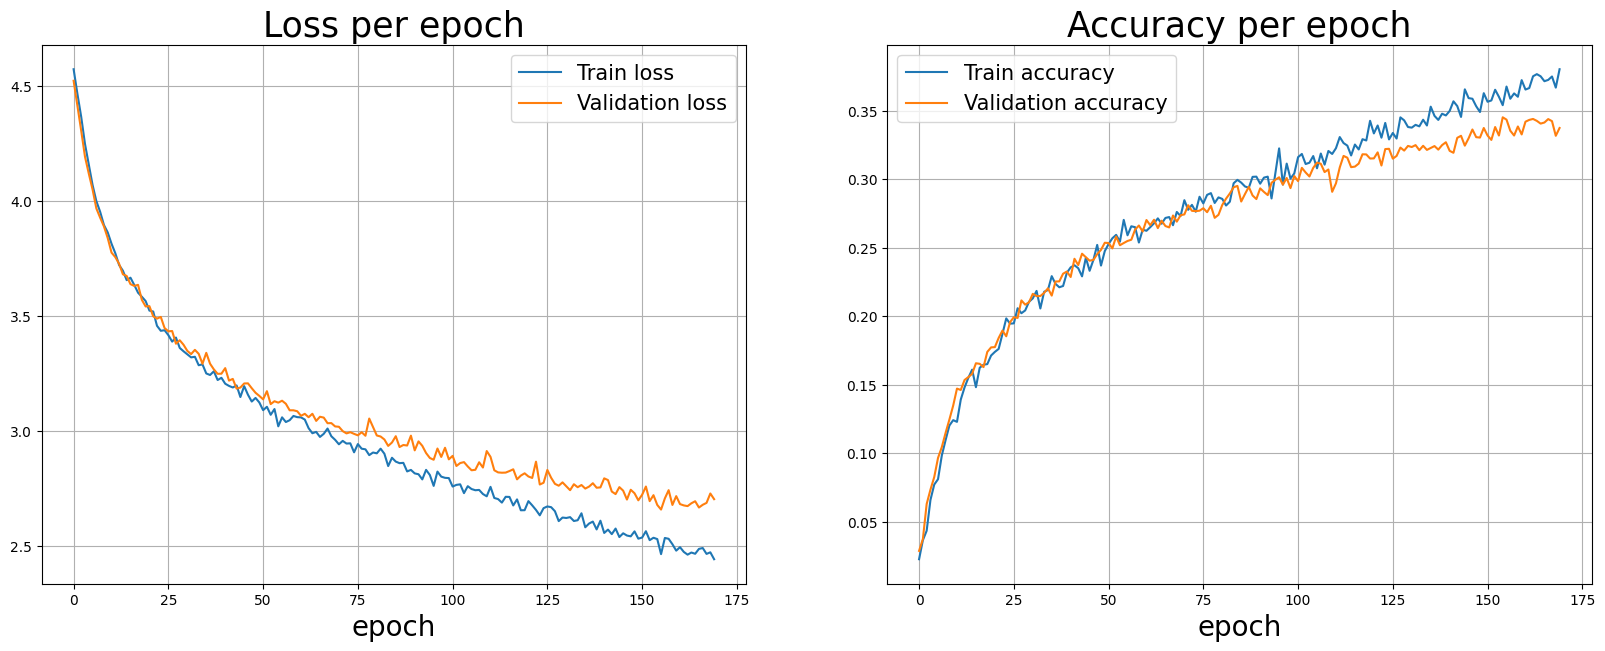

In [61]:
# plotting the learning curves
plot_results(history.history)

In [62]:
score = model_improved1.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 2.67753529548645
Val accuracy: 0.3452000021934509


### Using the Augmented data and the default data

In [55]:
# Training model
import time
training_start = time.time()
history = model_improved1.fit(train_datagen.flow(X_train_aug, y_train_aug, batch_size=64),
          steps_per_epoch=300,
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/200
300/300 [==============================] - 82s 224ms/step - loss: 4.4831 - acc: 0.0327 - val_loss: 4.2521 - val_acc: 0.0676
Epoch 2/200
300/300 [==============================] - 65s 215ms/step - loss: 4.0763 - acc: 0.0851 - val_loss: 3.9153 - val_acc: 0.1134
Epoch 3/200
300/300 [==============================] - 65s 215ms/step - loss: 3.8566 - acc: 0.1183 - val_loss: 3.7583 - val_acc: 0.1348
Epoch 4/200
300/300 [==============================] - 65s 217ms/step - loss: 3.7039 - acc: 0.1453 - val_loss: 3.6531 - val_acc: 0.1545
Epoch 5/200
300/300 [==============================] - 65s 215ms/step - loss: 3.6015 - acc: 0.1640 - val_loss: 3.5393 - val_acc: 0.1693
Epoch 6/200
300/300 [==============================] - 65s 215ms/step - loss: 3.5170 - acc: 0.1746 - val_loss: 3.4699 - val_acc: 0.1890
Epoch 7/200
300/300 [==============================] - 65s 215ms/step - loss: 3.4499 - acc: 0.1884 - val_loss: 3.4213 - val_acc: 0.1906
Epoch 8/200
300/300 [===========================

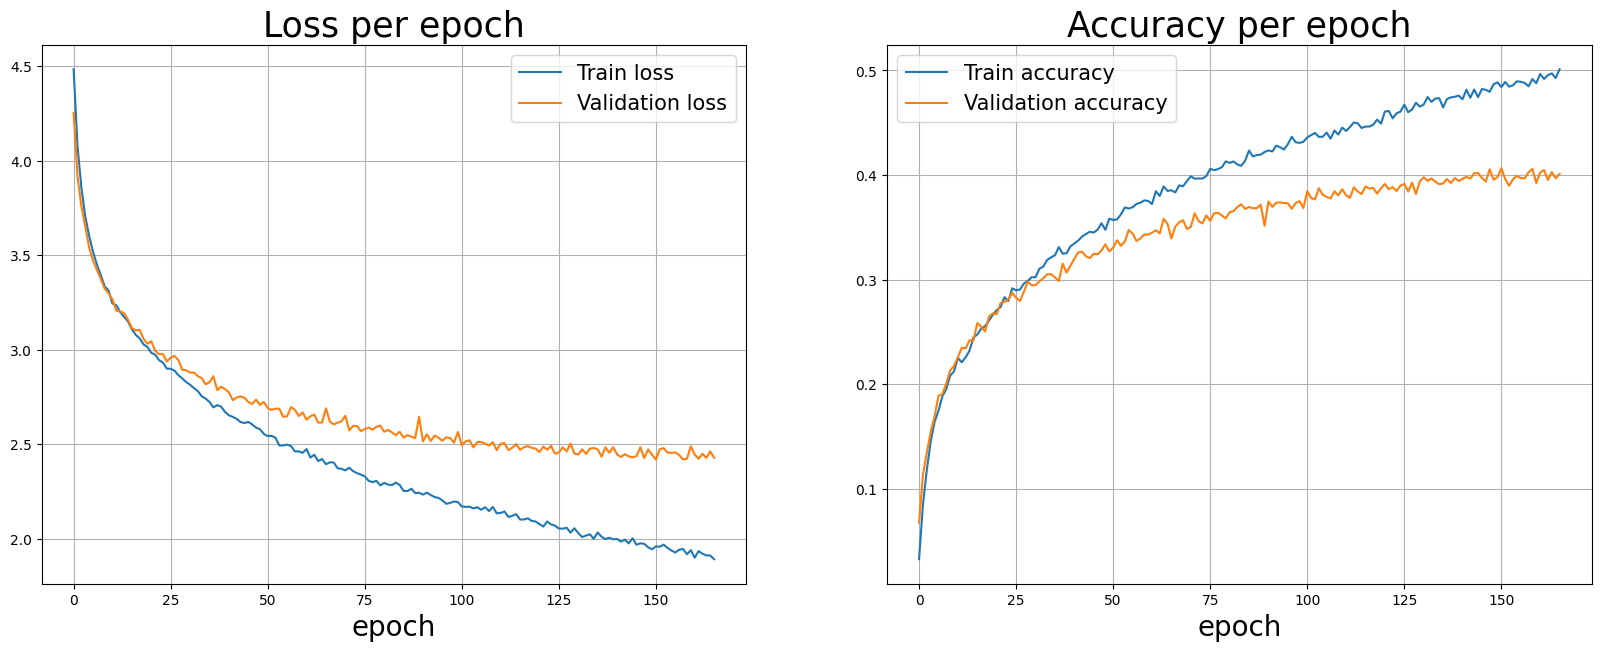

In [56]:
# plotting the learning curves
plot_results(history.history)

In [57]:
score = model_improved1.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 2.4191126823425293
Val accuracy: 0.4065000116825104


## Improved Model 2

In [14]:
# Batch norm model 4
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Dense,Activation,Dropout,Flatten

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
model_improved2 = Sequential()
 
model_improved2.add(Conv2D(256,(3,3),padding='same',input_shape=(32,32,3)))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(Conv2D(256,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(MaxPool2D(pool_size=(2,2)))
model_improved2.add(Dropout(0.2))
 
model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(MaxPool2D(pool_size=(2,2)))
model_improved2.add(Dropout(0.2))

model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(MaxPool2D(pool_size=(2,2)))
model_improved2.add(Dropout(0.2))

model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(Conv2D(512,(3,3),padding='same'))
model_improved2.add(BatchNormalization())
model_improved2.add(Activation('relu'))
model_improved2.add(MaxPool2D(pool_size=(2,2)))
model_improved2.add(Dropout(0.2))

model_improved2.add(Flatten())
model_improved2.add(Dense(1024))
model_improved2.add(Activation('relu'))
model_improved2.add(Dropout(0.2))
model_improved2.add(BatchNormalization(momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)))
model_improved2.add(Dense(100,activation='softmax'))
model_improved2.summary()

2022-11-25 12:50:09.647351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 12:50:09.653061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:50:09.653221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:50:09.653325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 32, 32, 256)       0

In [15]:
# Configure the model for training
from tensorflow.keras import optimizers
model_improved2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

### Without data Augmentation

In [32]:
#Model 2 without Data augmentation
#steps_per_epoch= params divided by batch_size
# Training model
import time
training_start = time.time()
history = model_improved2.fit(X_train, y_train, batch_size=64, steps_per_epoch=300, epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")
# Training model
import time

Epoch 1/200
300/300 [==============================] - 23s 63ms/step - loss: 4.3186 - acc: 0.0661 - val_loss: 5.0775 - val_acc: 0.0231
Epoch 2/200
300/300 [==============================] - 19s 62ms/step - loss: 3.7722 - acc: 0.1297 - val_loss: 3.9571 - val_acc: 0.1036
Epoch 3/200
300/300 [==============================] - 19s 64ms/step - loss: 3.3863 - acc: 0.1913 - val_loss: 3.2026 - val_acc: 0.2180
Epoch 4/200
300/300 [==============================] - 19s 63ms/step - loss: 3.0953 - acc: 0.2410 - val_loss: 3.0620 - val_acc: 0.2563
Epoch 5/200
300/300 [==============================] - 19s 64ms/step - loss: 2.8025 - acc: 0.2945 - val_loss: 2.7434 - val_acc: 0.3149
Epoch 6/200
300/300 [==============================] - 19s 63ms/step - loss: 2.5311 - acc: 0.3449 - val_loss: 2.3485 - val_acc: 0.3900
Epoch 7/200
300/300 [==============================] - 19s 63ms/step - loss: 2.3862 - acc: 0.3796 - val_loss: 2.4275 - val_acc: 0.3832
Epoch 8/200
300/300 [==============================] - 

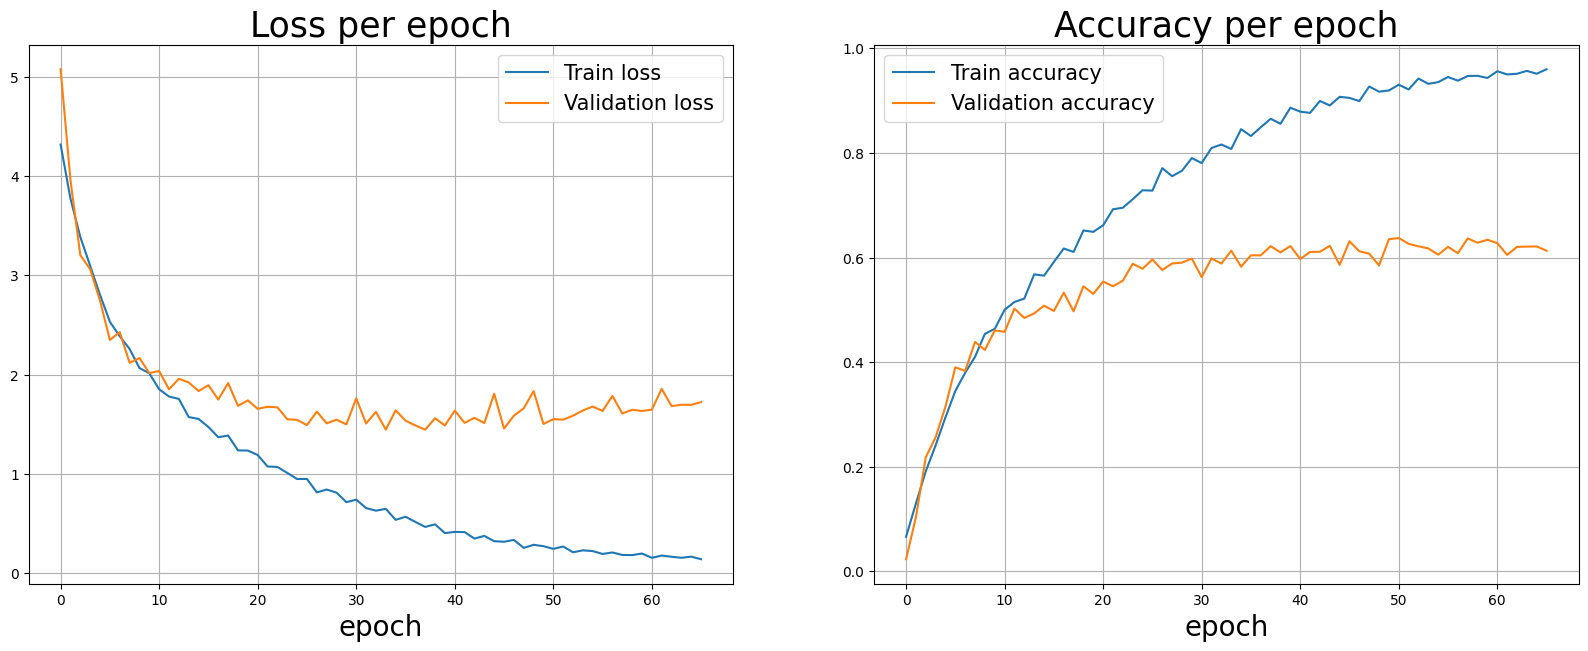

In [33]:
# plotting the learning curves
plot_results(history.history)

In [34]:
score = model_improved2.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.5499601364135742
Val accuracy: 0.6371999979019165


### With data Augmentation

### Using the Augmented data

In [16]:
# Training model
import time
training_start = time.time()
history = model_improved2.fit(train_datagen.flow(X_train, y_train, batch_size=64),
          steps_per_epoch=300, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/200


2022-11-25 12:50:26.317012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2022-11-25 12:50:27.645774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-25 12:50:31.166508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-25 12:50:31.448847: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f224dbb03f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-25 12:50:31.448869: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2022-11-25 12:50:31.518262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_uti

299/300 [============================>.] - ETA: 0s - loss: 4.3422 - acc: 0.0653

2022-11-25 12:50:45.300907: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
2022-11-25 12:50:45.371211: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


300/300 [==============================] - 23s 45ms/step - loss: 4.3404 - acc: 0.0655 - val_loss: 5.1879 - val_acc: 0.0249
Epoch 2/200
300/300 [==============================] - 13s 42ms/step - loss: 3.8042 - acc: 0.1287 - val_loss: 3.9017 - val_acc: 0.1158
Epoch 3/200
300/300 [==============================] - 13s 42ms/step - loss: 3.5032 - acc: 0.1733 - val_loss: 3.3748 - val_acc: 0.2057
Epoch 4/200
300/300 [==============================] - 13s 43ms/step - loss: 3.2342 - acc: 0.2153 - val_loss: 2.9647 - val_acc: 0.2678
Epoch 5/200
300/300 [==============================] - 13s 42ms/step - loss: 3.0210 - acc: 0.2578 - val_loss: 2.8166 - val_acc: 0.2918
Epoch 6/200
300/300 [==============================] - 13s 42ms/step - loss: 2.8187 - acc: 0.2949 - val_loss: 2.9012 - val_acc: 0.2832
Epoch 7/200
300/300 [==============================] - 13s 42ms/step - loss: 2.6784 - acc: 0.3163 - val_loss: 2.5791 - val_acc: 0.3448
Epoch 8/200
300/300 [==============================] - 13s 42ms/ste

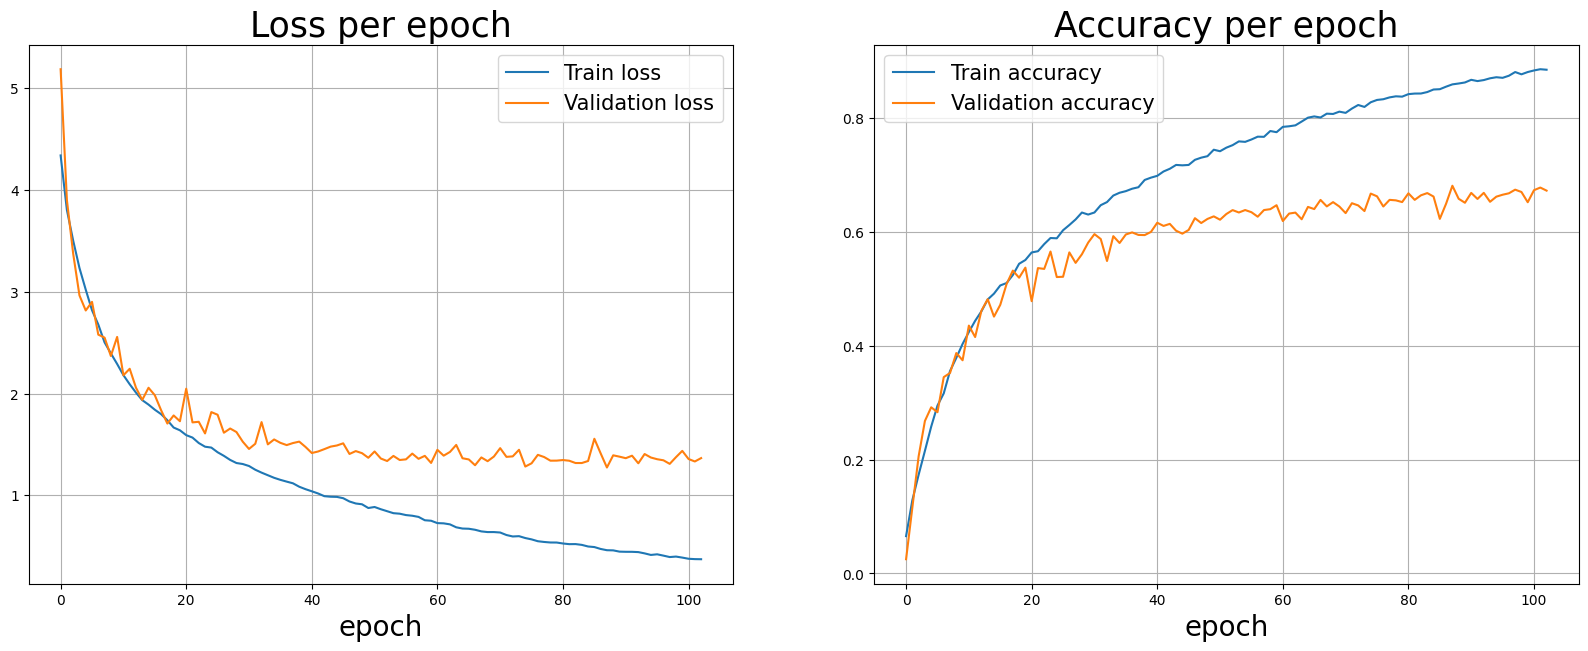

In [17]:
# plotting the learning curves
plot_results(history.history)

In [18]:
score = model_improved2.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

2022-11-25 13:30:14.075135: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.
2022-11-25 13:30:14.352388: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 122880000 exceeds 10% of free system memory.


Val loss: 1.2731174230575562
Val accuracy: 0.6809999942779541


Model severely overfits the train data which cauzes the test data to be very low

### Using the Augmented data and the default data

In [45]:
# Training model
import time
training_start = time.time()
history = model_improved2.fit(train_datagen.flow(X_train_aug, y_train_aug, batch_size=64),
          steps_per_epoch=300, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/200
300/300 [==============================] - 21s 66ms/step - loss: 4.3628 - acc: 0.0654 - val_loss: 5.2424 - val_acc: 0.0288
Epoch 2/200
300/300 [==============================] - 19s 64ms/step - loss: 3.8169 - acc: 0.1221 - val_loss: 3.9006 - val_acc: 0.1089
Epoch 3/200
300/300 [==============================] - 19s 64ms/step - loss: 3.5074 - acc: 0.1716 - val_loss: 3.4101 - val_acc: 0.1976
Epoch 4/200
300/300 [==============================] - 19s 64ms/step - loss: 3.2514 - acc: 0.2124 - val_loss: 3.3231 - val_acc: 0.2075
Epoch 5/200
300/300 [==============================] - 19s 64ms/step - loss: 3.0291 - acc: 0.2546 - val_loss: 2.8923 - val_acc: 0.2897
Epoch 6/200
300/300 [==============================] - 19s 64ms/step - loss: 2.8501 - acc: 0.2840 - val_loss: 2.9810 - val_acc: 0.2752
Epoch 7/200
300/300 [==============================] - 19s 64ms/step - loss: 2.7071 - acc: 0.3150 - val_loss: 2.9559 - val_acc: 0.2877
Epoch 8/200
300/300 [==============================] - 

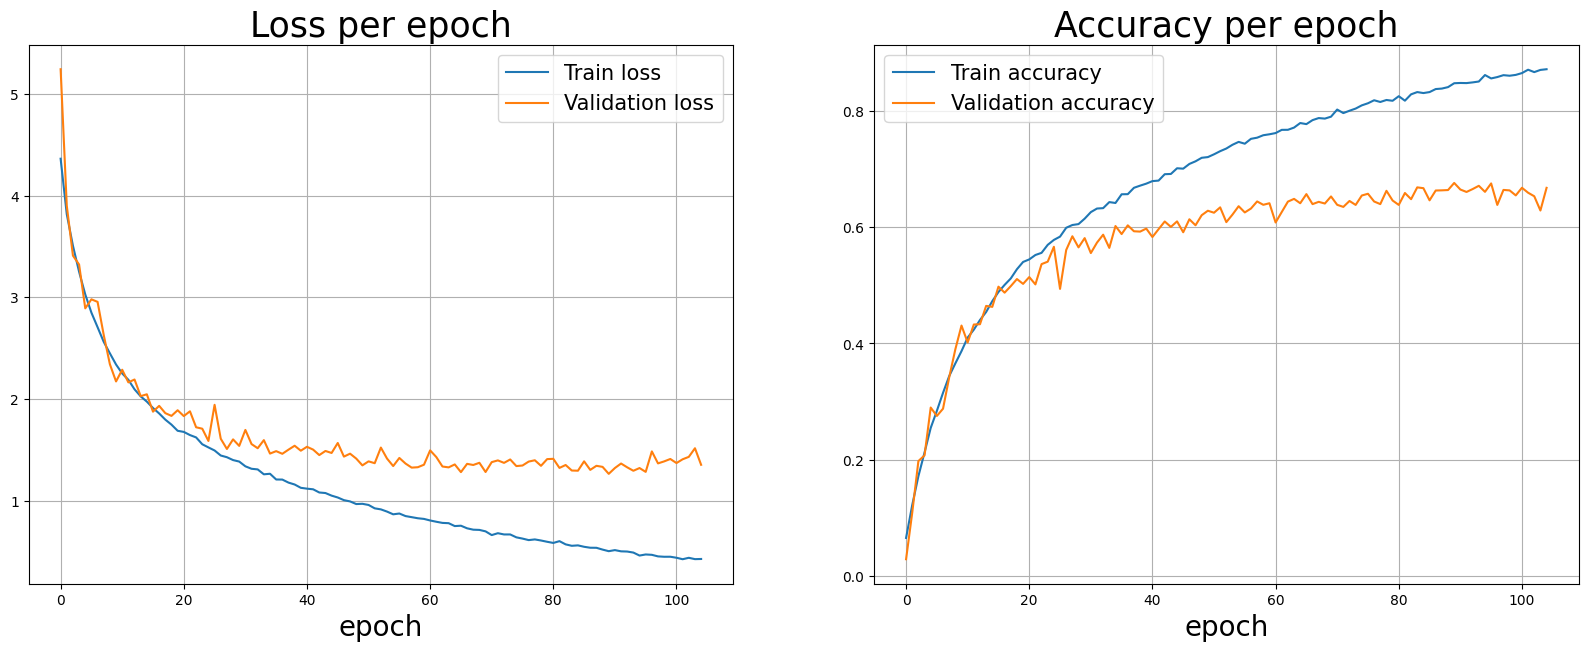

In [46]:
# plotting the learning curves
plot_results(history.history)

In [47]:
score = model_improved2.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.265762448310852
Val accuracy: 0.6759999990463257


# Hyperparameter Search (Keras Tuner: Random Search)

Tune the best model, which is improved model 2 using the Augmented data and the default data, with the higher validation accuracy and lower validation loss (With no overfitting).

    -Parameters input dropout to between 0.1 and 0.2 because dropping the input data can adversely affect the training.
    -Parameters intermediate dropout to 0.5 and below because 0.5 is ideal for large datasets and >0.5 is not advised it may cull more connections without boosting the regularization.


In [59]:
def tune_model(hp):
    first_dropout=hp.Float('dropout',min_value=0.1, max_value=0.2, sampling="log")
    intermediate_dropout=hp.Float('dropout',min_value=0.1, max_value=0.5, sampling="log")
    
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    
    model = tf.keras.Sequential()

    model.add(Conv2D(256,(3,3),padding='same',input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(first_dropout))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(intermediate_dropout))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(intermediate_dropout))

    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(512,(3,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(intermediate_dropout))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(intermediate_dropout))
    model.add(BatchNormalization(momentum=0.95, 
            epsilon=0.005,
            beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
            gamma_initializer=Constant(value=0.9)))
    model.add(Dense(100,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate),
              metrics=['acc'])
    model.summary()
    return model

Using RandomSearch in keras tuner

In [60]:
import keras_tuner as kt
tuner = kt.RandomSearch(tune_model,
                     objective='val_acc',
                     max_trials=5,
                     overwrite=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 32, 32, 256)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 32, 32, 256)      

In [61]:
from tensorflow.keras.models import Sequential
tuner.search((train_datagen.flow(X_train_aug, y_train_aug, batch_size=64)), epochs=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(
    monitor='val_acc',
    patience=15,
    min_delta=0.0000001,
    restore_best_weights=True,
)])
tuner.results_summary(num_trials=3)

Trial 5 Complete [00h 42m 50s]
val_acc: 0.6762999892234802

Best val_acc So Far: 0.6773999929428101
Total elapsed time: 03h 46m 16s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 3 best trials
Trial summary
Hyperparameters:
dropout: 0.11680940233031101
learning_rate: 0.0001
Score: 0.6773999929428101
Trial summary
Hyperparameters:
dropout: 0.1302641091963073
learning_rate: 0.0001
Score: 0.6762999892234802
Trial summary
Hyperparameters:
dropout: 0.1226629950461613
learning_rate: 0.001
Score: 0.6502000093460083


In [62]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [63]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.2, 'step': None, 'sampling': 'log'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [65]:
# Training model
import time
training_start = time.time()
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_datagen.flow(X_train_aug, y_train_aug, batch_size=64),
          steps_per_epoch=300, 
          epochs=200,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[early_stopping])
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 activation_19 (Activation)  (None, 32, 32, 256)      

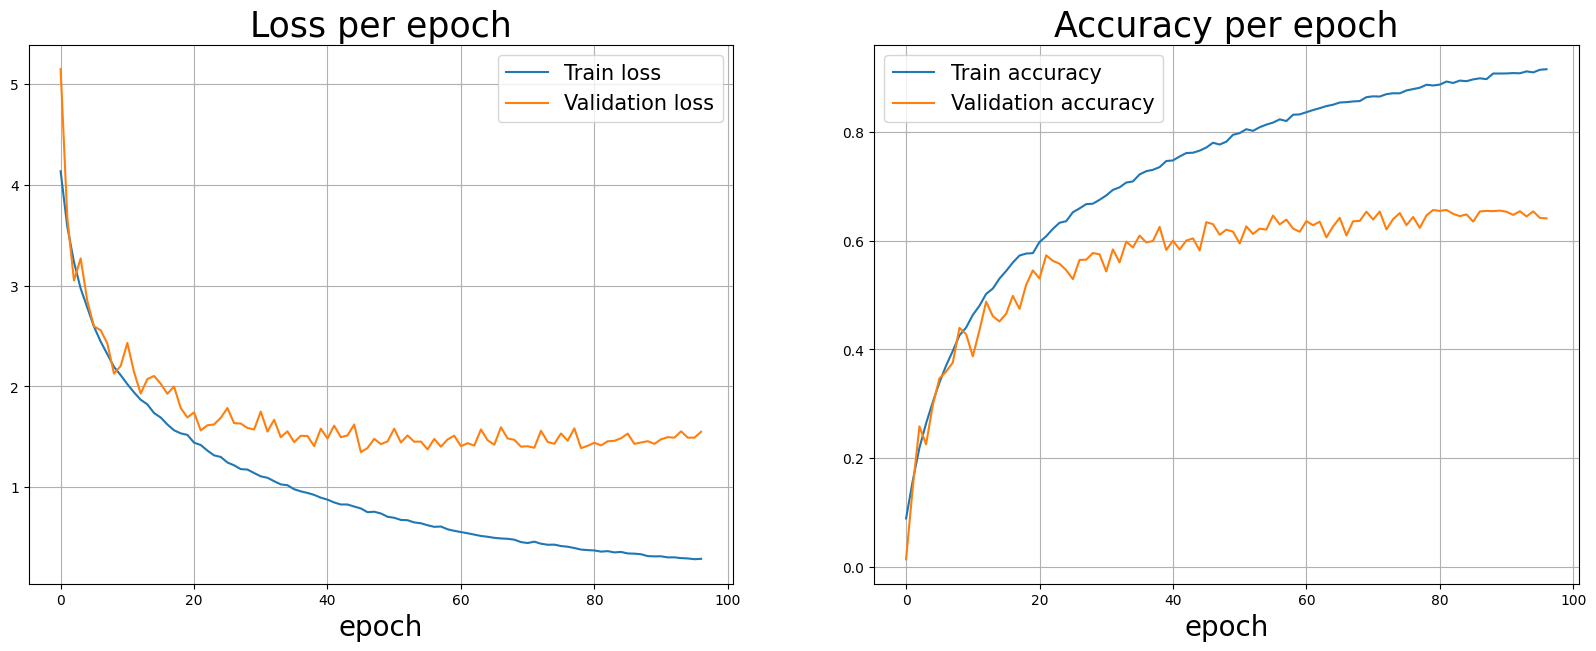

In [66]:
# plotting the learning curves
plot_results(history.history)

Scores show lower validation accuracy and higher validation loss

In [67]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 1.4150466918945312
Val accuracy: 0.6561999917030334


# Predictions on the test set

Now, let’s use our best model before and after the hypertuning to make predictions on the test set and check our results.

In [107]:
# To plot the visualisation of the predictions
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == list(true_label).index(1):
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[list(true_label).index(1)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i],true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(100), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[list(true_label).index(1)].set_color('blue')
    

# Improved Model 2 Prediction

In [109]:
from sklearn.metrics import accuracy_score

In [110]:
predict= model_improved2.predict(X_test)

313/313 [==============================] - 3s 8ms/step


In [111]:
pred_labels=np.argmax(predict, axis=1)

In [112]:
eval_result = model_improved2.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 3s 10ms/step - loss: 1.3366 - acc: 0.6476
[test loss, test accuracy]: [1.3365967273712158, 0.647599995136261]


In [113]:
import sklearn.metrics as metrics
print(metrics.classification_report(data['Class'], pred_labels, target_names=class_names))

                   precision    recall  f1-score   support

            apple       0.93      0.79      0.85       100
    aquarium_fish       0.73      0.80      0.76       100
             baby       0.58      0.56      0.57       100
             bear       0.55      0.48      0.51       100
           beaver       0.55      0.38      0.45       100
              bed       0.69      0.58      0.63       100
              bee       0.70      0.78      0.74       100
           beetle       0.60      0.73      0.66       100
          bicycle       0.82      0.84      0.83       100
           bottle       0.79      0.71      0.75       100
             bowl       0.64      0.42      0.51       100
              boy       0.52      0.37      0.43       100
           bridge       0.64      0.74      0.69       100
              bus       0.49      0.75      0.59       100
        butterfly       0.48      0.82      0.61       100
            camel       0.65      0.71      0.68       

Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label.

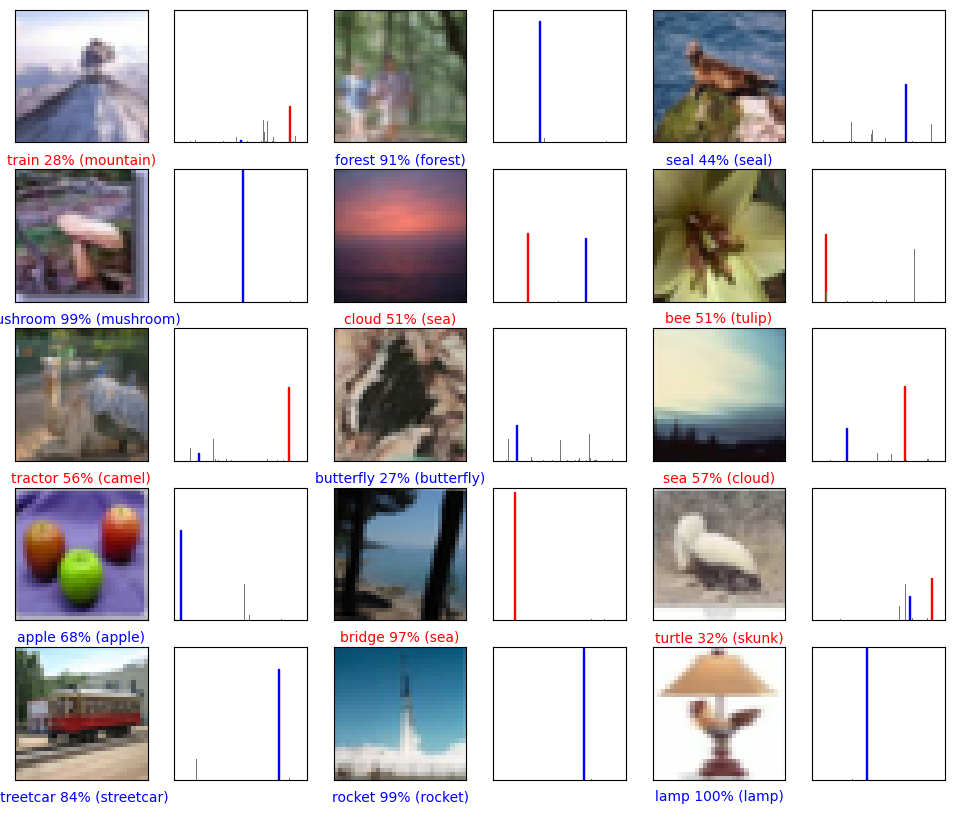

In [114]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predict, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predict, y_test)
plt.show()

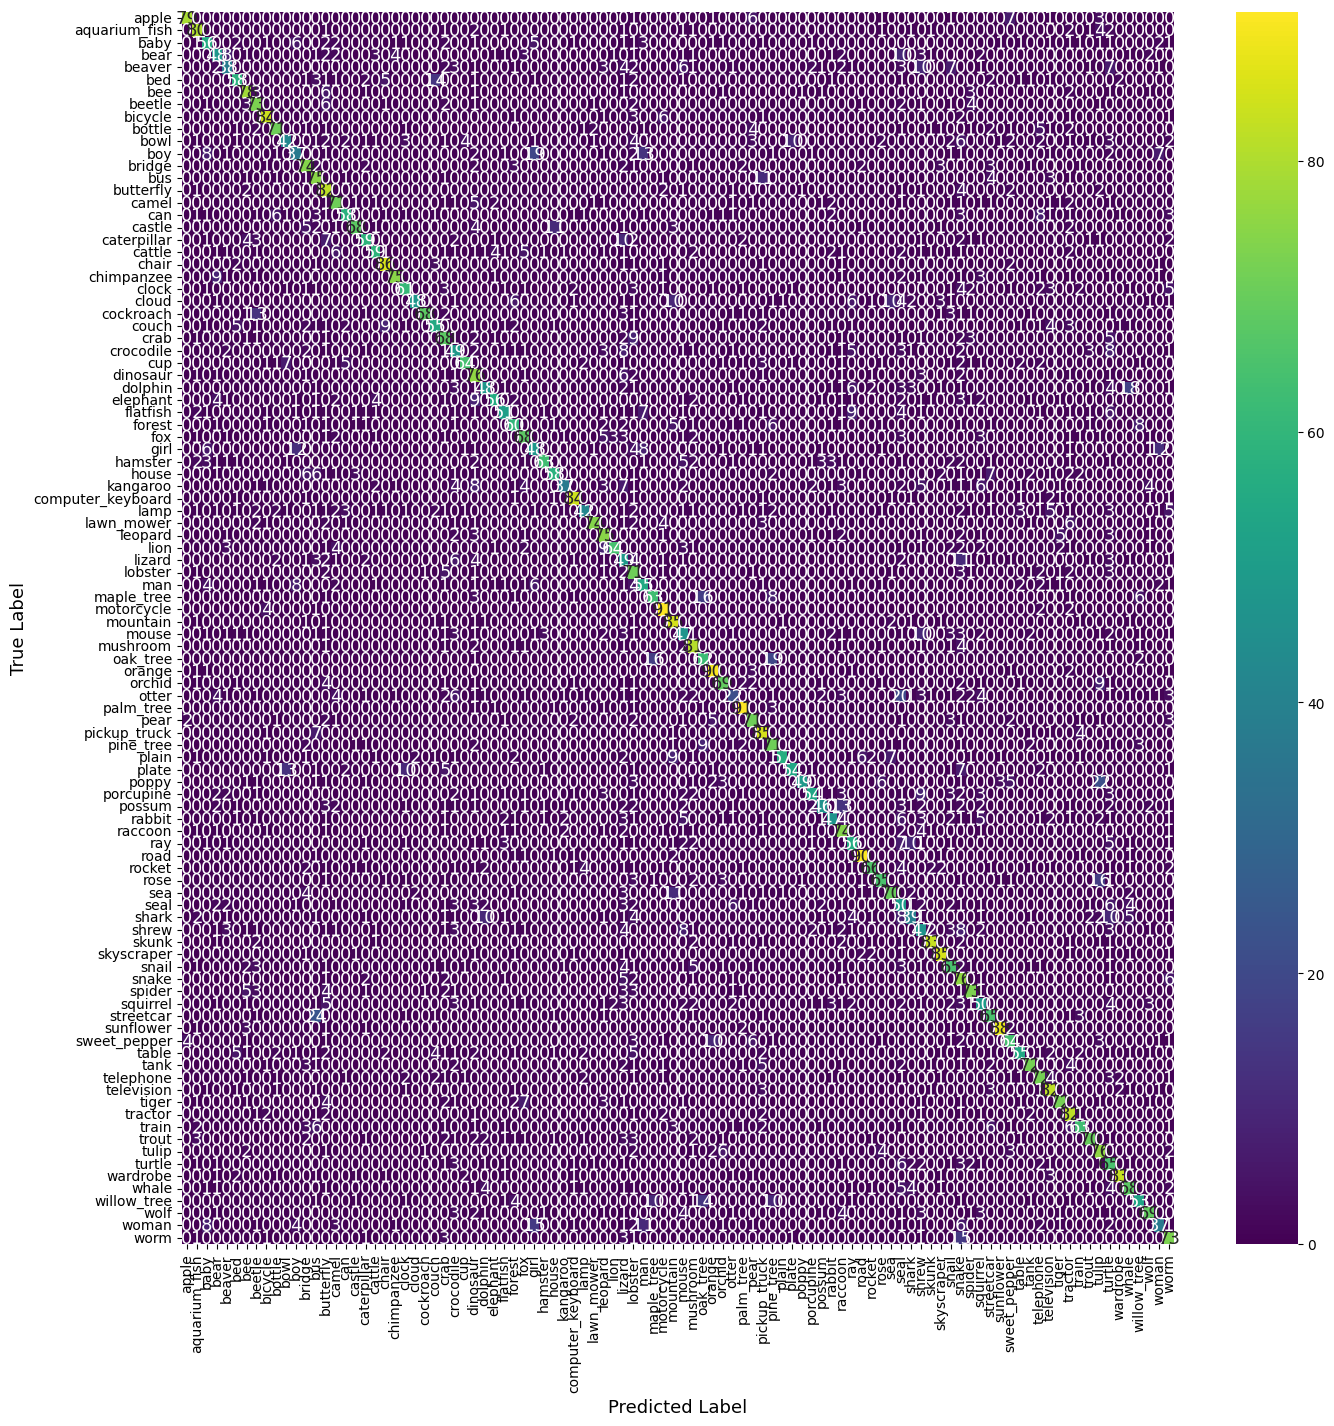

In [115]:
import seaborn as sns
prob_confusion_matrix = metrics.confusion_matrix(data['Class'], pred_labels)

plt.figure(figsize=(16,16))

sns.heatmap(prob_confusion_matrix, annot=True, fmt="d", cmap = 'viridis'
           , xticklabels = class_names, yticklabels = class_names, annot_kws={'size': 13})
            
plt.xlabel("Predicted Label", fontsize= 13)
plt.ylabel("True Label", fontsize= 13)

plt.show()

# Improved Model 2 Prediction AFTER Hypertuning

In [70]:
predict= model.predict(X_test)

313/313 [==============================] - 3s 8ms/step


In [71]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 3s 10ms/step - loss: 1.4150 - acc: 0.6562
[test loss, test accuracy]: [1.4150466918945312, 0.6561999917030334]


In [72]:
pred_labels=np.argmax(predict, axis=1)

In [73]:
import sklearn.metrics as metrics
print(metrics.classification_report(data['Class'], pred_labels, target_names=class_names))

                   precision    recall  f1-score   support

            apple       0.97      0.77      0.86       100
    aquarium_fish       0.93      0.78      0.85       100
             baby       0.68      0.50      0.58       100
             bear       0.67      0.42      0.52       100
           beaver       0.50      0.57      0.53       100
              bed       0.75      0.59      0.66       100
              bee       0.69      0.79      0.74       100
           beetle       0.79      0.64      0.71       100
          bicycle       0.87      0.80      0.83       100
           bottle       0.49      0.82      0.61       100
             bowl       0.63      0.44      0.52       100
              boy       0.45      0.32      0.37       100
           bridge       0.68      0.79      0.73       100
              bus       0.55      0.65      0.60       100
        butterfly       0.63      0.72      0.67       100
            camel       0.57      0.71      0.63       

In [74]:
text =  open('predictions','w')
text.write(np.array2string(pred_labels))
text.close()
    

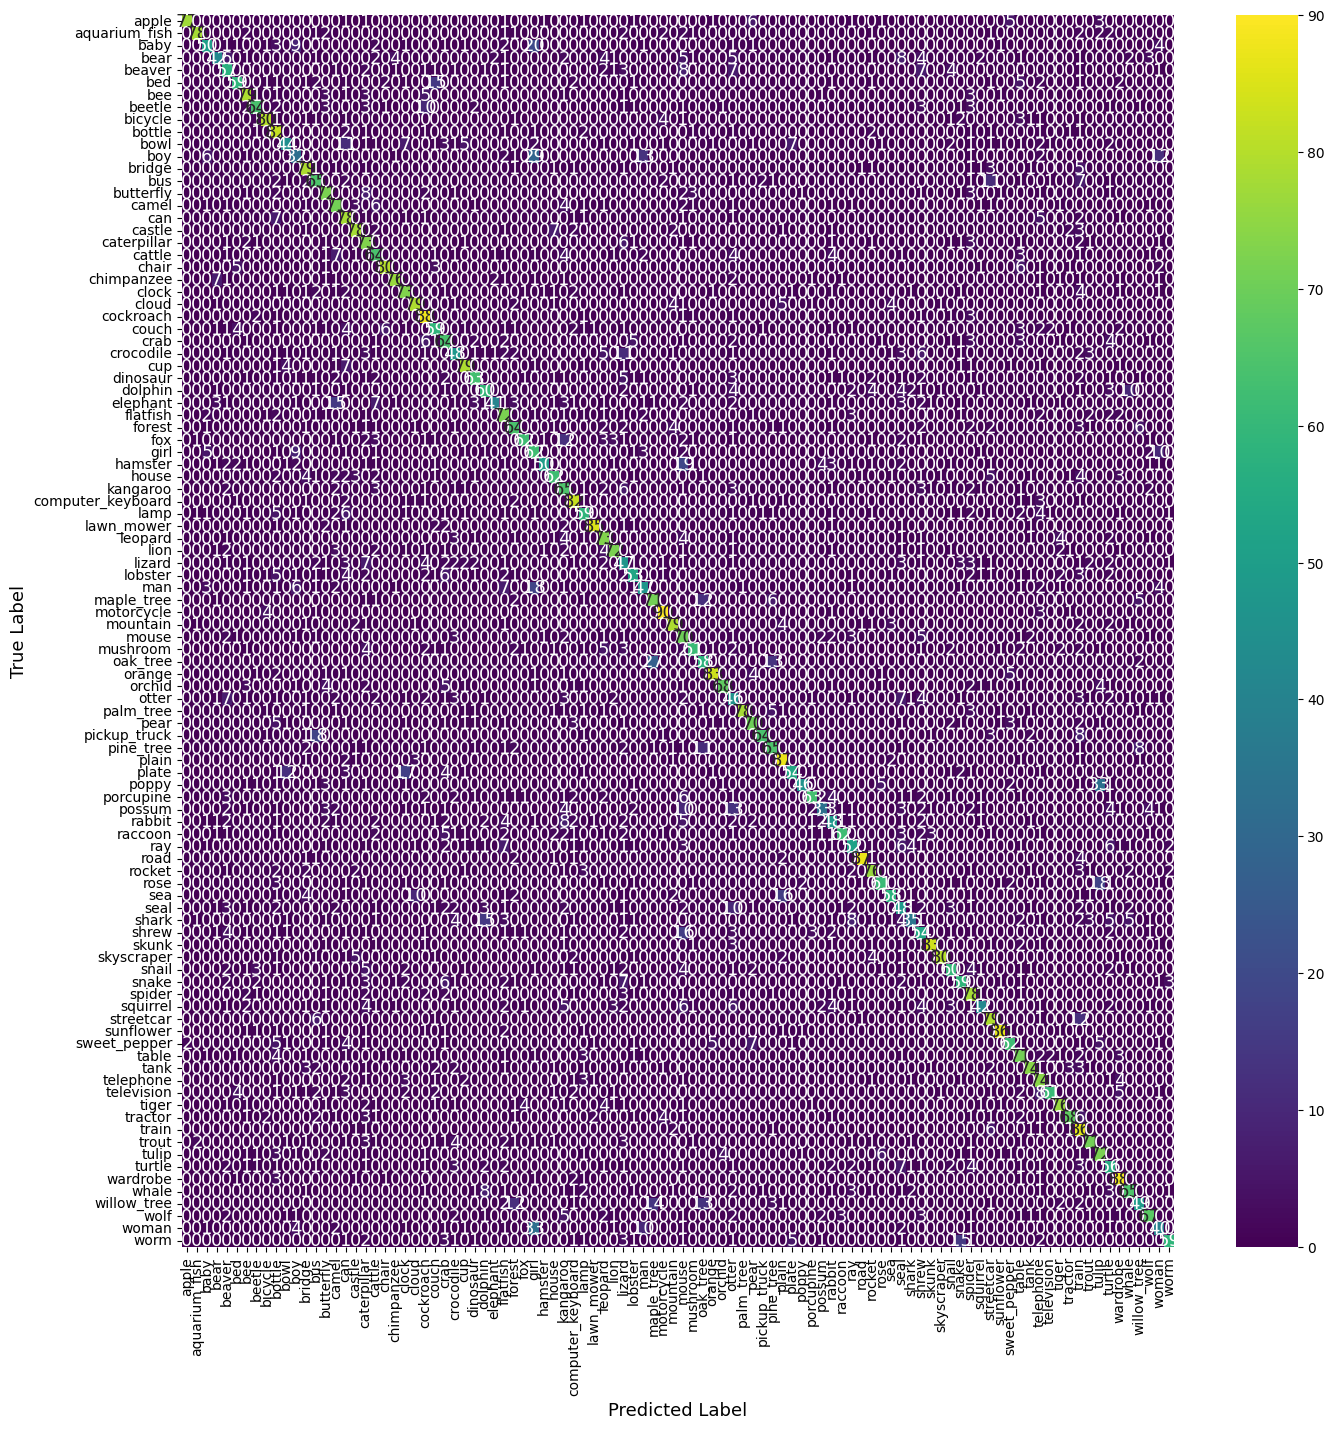

In [75]:
import seaborn as sns
prob_confusion_matrix = metrics.confusion_matrix(data['Class'], pred_labels)

plt.figure(figsize=(16,16))

sns.heatmap(prob_confusion_matrix, annot=True, fmt="d", cmap = 'viridis'
           , xticklabels = class_names, yticklabels = class_names, annot_kws={'size': 13})
            
plt.xlabel("Predicted Label", fontsize= 13)
plt.ylabel("True Label", fontsize= 13)

plt.show()

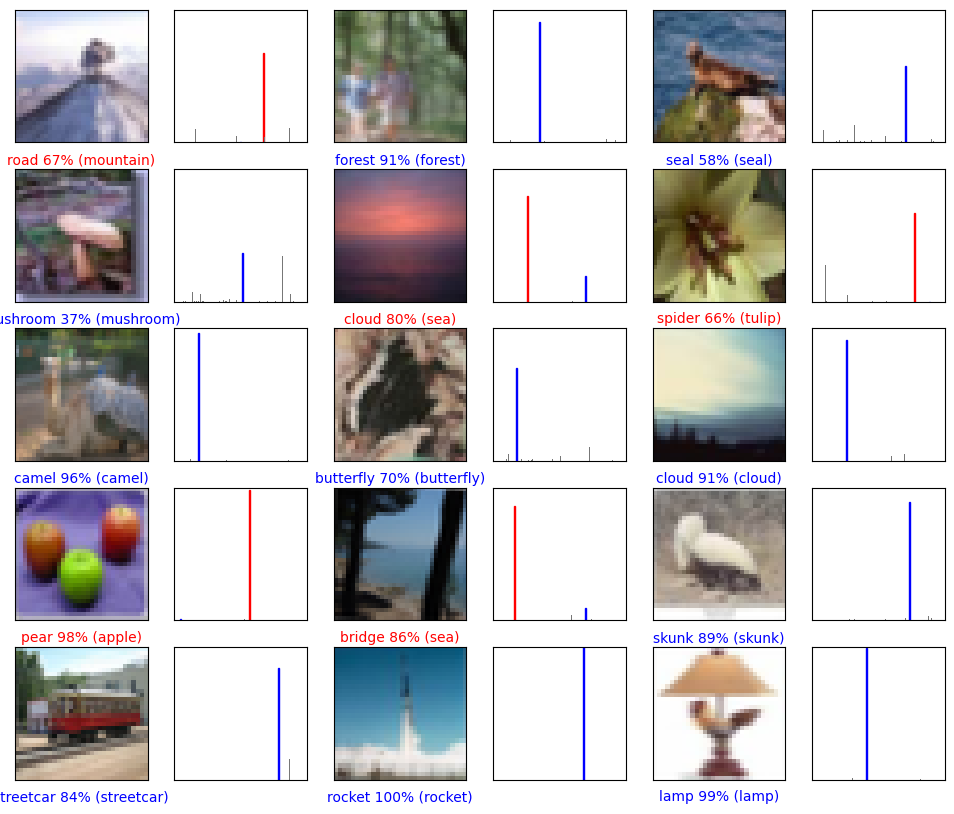

In [108]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predict, y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predict, y_test)
plt.show()

# Save my models

## Improved Model 1

In [142]:
# Save model weights
tf.keras.models.save_model(
    model_improved1,
    "model_improved1.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

## Save my best model (Improved Model 2)

In [116]:
# Save model weights
tf.keras.models.save_model(
    model_improved2,
    "model_improved2.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

## Tuned Improved Model 2

In [144]:
# Save model weights
tf.keras.models.save_model(
    model,
    "tuned_model.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)